In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import scipy.io 
import sys
sys.path.append('/Users/yjzhu/Desktop/Solar/MyPy')
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFitSingle, SpectrumFitRow
import cmcrameri.cm as cmcm
import sumerpy
importlib.reload(sumerpy)
import corner
import mycorner
importlib.reload(mycorner)
from sumerpy import con_width_funct_4, radiometry
from matplotlib.colors import LinearSegmentedColormap
import cmcrameri.cm as cmcm

In [2]:
sumer_img = scipy.io.readsav("../../save/sumer_merg.sav")["int_merg"]
wvl_607 = np.linspace(0,1023,1024)*0.04316670824233466 + 1209.3346601414057
sumer_607_window = sumer_img[:,3072:]
sumer_607_window.shape
sumer_ycen = 1119.81
sumer_ycoord = np.linspace(sumer_ycen-299.2/2,sumer_ycen+299.2/2,300) - 5
np.set_printoptions(precision=2)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:621: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


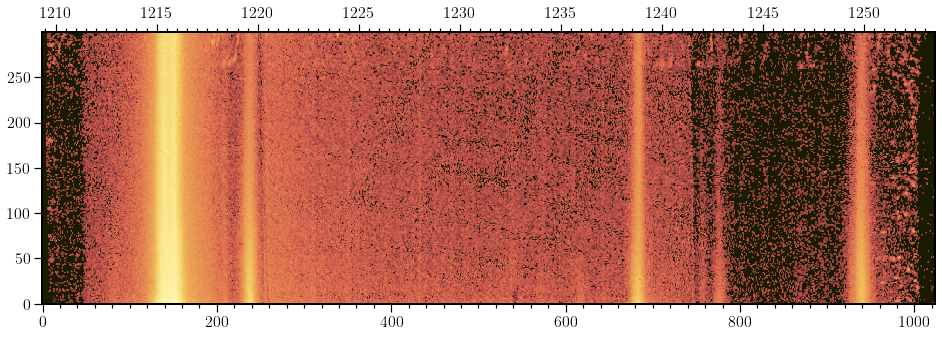

In [3]:
fig, ax = plt.subplots(figsize=(16,5))
ax.pcolormesh(np.arange(1024),np.arange(299,-1,-1),np.nan_to_num(np.log10(sumer_607_window),nan=-np.inf),
                  cmap=cmcm.lajolla_r,shading="auto",vmin=-5)

ax_wvl = ax.twiny()
ax_wvl.set_xlim(wvl_607[0],wvl_607[-1])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
ax_wvl.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
for ax_ in (ax, ax_wvl):
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",width=1.2,length=8)
    ax_.tick_params(which="minor",width=1.2,length=4)

(0.0, 10.0)

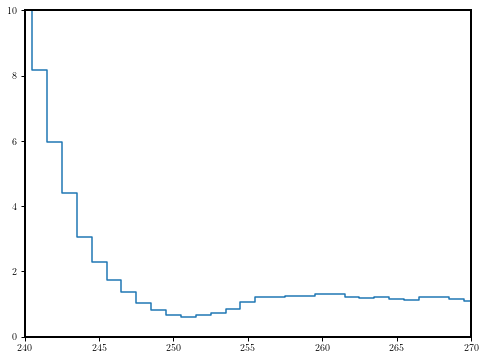

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.step(np.arange(1024),np.sum(sumer_607_window,axis=0),where="mid")
ax.set_xlim(240,270)
ax.set_ylim(0,10)

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [145.1]


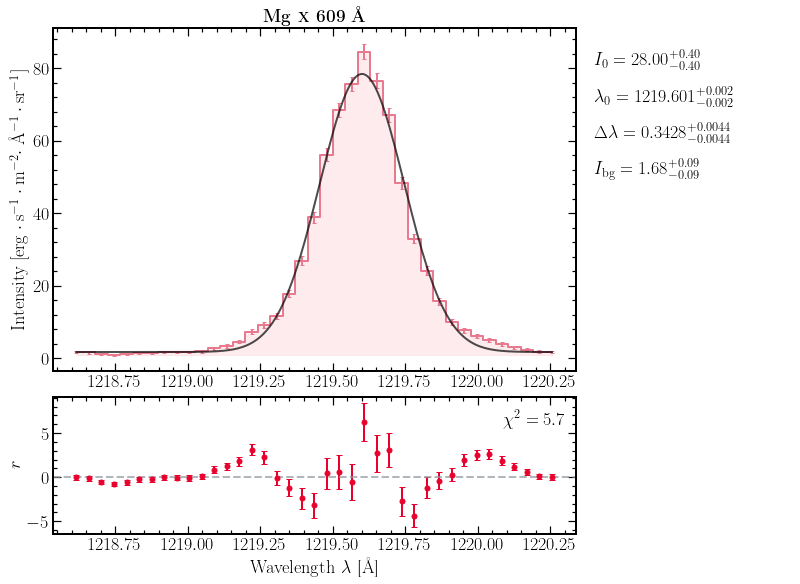

In [112]:
MgX_609_slice = (215,254)
wvl_MgX_609 = wvl_607[MgX_609_slice[0]:MgX_609_slice[1]]
radiometry_MgX_609 = radiometry(1,wvl_MgX_609/2.,2,np.ones_like(wvl_MgX_609),bare=True,kbr=False,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
int_MgX_609 = np.average(sumer_607_window[-30:,MgX_609_slice[0]:MgX_609_slice[1]],axis=0)*radiometry_MgX_609
err_MgX_609 = np.sqrt(np.sum(300*sumer_607_window[-30:,MgX_609_slice[0]:MgX_609_slice[1]],
                        axis=0))/30/300*radiometry_MgX_609
                        
MgX_609_fit_model = SpectrumFitSingle(data=int_MgX_609,wvl=wvl_MgX_609,err=err_MgX_609,
                                      same_width=False,line_number=1,line_wvl_init=[1219.5],
                                      int_max_init=[80],fwhm_init=[0.2])
#MgX_609_fit_model.plot(plot_fit=False,plot_params=False)
#MgX_609_fit_model.run_lse()
MgX_609_fit_model.run_HahnMC(n_chain=10000,save_chain=True)
MgX_609_fit_model.plot(plot_title=r"\textbf{Mg \textsc{x} 609 \mbox{\AA}}",plot_hmc=True,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot m^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,MgX_609_fit_model.line_wvl_fit_hmc/2.,2,MgX_609_fit_model.fwhm_fit_hmc*1000./2.,DET_B=True))

/Users/yjzhu/Desktop/Solar/MyPy/mycorner.py:239: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  wspace=whspace, hspace=whspace)


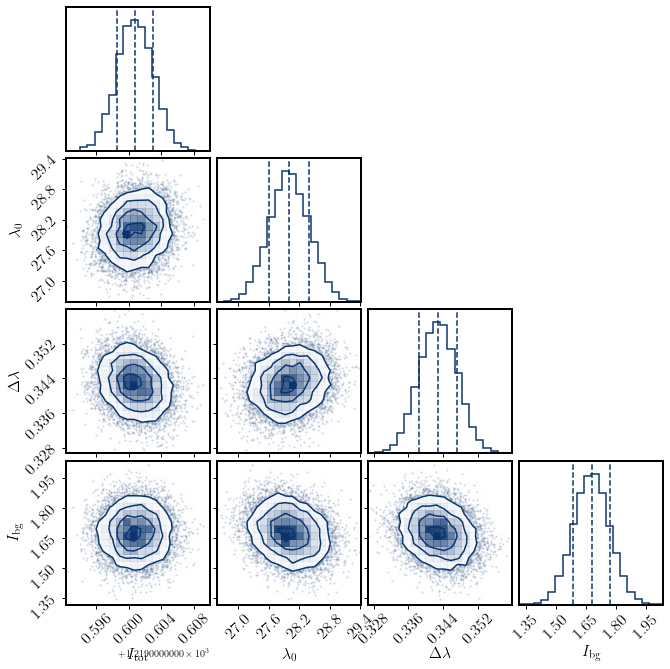

In [113]:
fig = mycorner.corner(MgX_609_fit_model.HahnMC_chain,quantiles=[0.16,0.5,0.84],
color="#0B346E",bins=20,data_kwargs={"alpha":0.2},hist_kwargs={"linewidth":1.5},
use_math_text=True,labels=[r"$I_{\rm tot}$",r"$\lambda_0$",r"$\Delta \lambda$",r"$I_{\rm bg}$"])

axes = np.array(fig.axes).reshape((4,4))

for ax_ in axes.flatten():
    ax_.tick_params(labelsize=16)
    ax_.xaxis.label.set_size(16)
    ax_.yaxis.label.set_size(16)
    #ax_.xaxis.get_offset_text().set_size(0)

FWHM after removing instrumental broadening:  [103.   260.36]


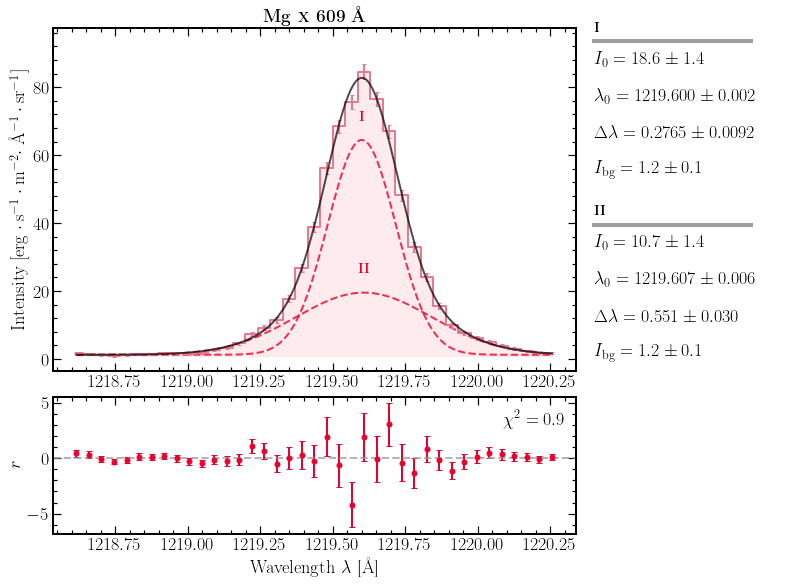

In [114]:
MgX_609_fit_model = SpectrumFitSingle(data=int_MgX_609,wvl=wvl_MgX_609,err=err_MgX_609,
                                      same_width=False,line_number=2,line_wvl_init=[1219.5,1219.5],
                                      int_max_init=[80,10],fwhm_init=[0.3,0.6])
#MgX_609_fit_model.plot(plot_fit=False,plot_params=False)
MgX_609_fit_model.run_lse()
# MgX_609_fit_model.run_HahnMC(n_chain=10000)
MgX_609_fit_model.plot(plot_title=r"\textbf{Mg \textsc{x} 609 \mbox{\AA}}",plot_hmc=False,
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot m^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,MgX_609_fit_model.line_wvl_fit/2.,2,MgX_609_fit_model.fwhm_fit*1000./2.,DET_B=True))

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:202: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
No handles with labels found to put in legend.


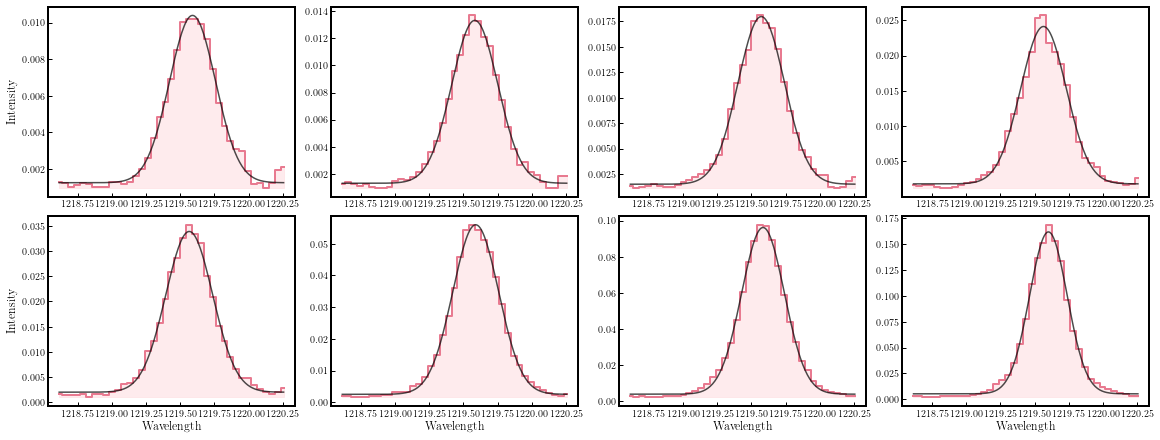

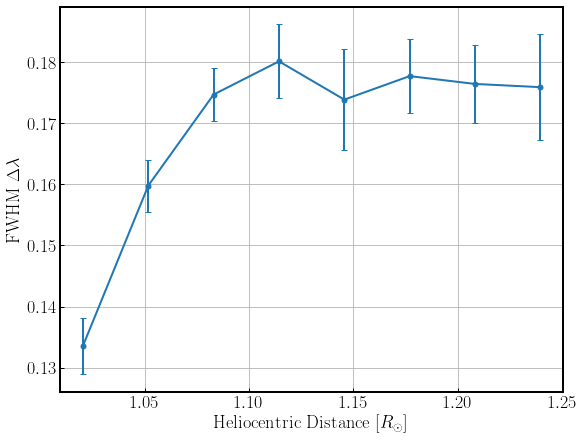

In [115]:
int_MgX_609_row = np.average(sumer_607_window[-240:,MgX_609_slice[0]:MgX_609_slice[1]].reshape(-1,30,MgX_609_slice[1]-MgX_609_slice[0]),axis=1)

MgX_609_fit_row_model = SpectrumFitRow(data=int_MgX_609_row,wvl=wvl_MgX_609,err=None,
                                      same_width=False,line_number=1,line_wvl_init=[1219.5],
                                      int_max_init=[0.5],fwhm_init=[0.2])
MgX_609_fit_row_model.run_lse()
MgX_609_fit_row_model.plot_fit()
MgX_609_fit_row_model.fwhm_fit = con_width_funct_4(1,MgX_609_fit_row_model.line_wvl_fit/2.,2, MgX_609_fit_row_model.fwhm_fit*1000./2.,DET_B=True)/1000
ax = MgX_609_fit_row_model.plot_variation(xdata=np.flip(np.average(sumer_ycoord[:240].reshape(-1,30),axis=1))/960,
                                            xlabel=r"Heliocentric Distance $\left[R_\odot \right]$")
ax.grid("on")

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


<AxesSubplot:title={'center':'\\textbf{Fe \\textsc{xii} 1242 \\mbox{\\AA} \\& Si \\textsc{x} 621 \\mbox{\\AA}}'}, ylabel='Intensity $\\mathrm{[erg\\cdot s^{-1}\\cdot m^{-2}\\cdot}$ \\mbox{\\AA}$\\mathrm{^{-1}\\cdot sr^{-1}]}$'>

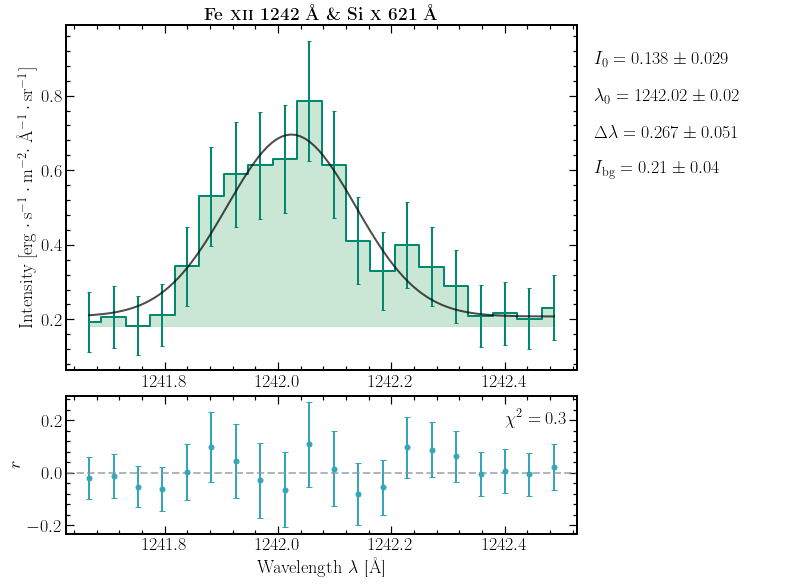

In [116]:
FeXII_1242_slice = (749,769)
wvl_FeXII_1242 = wvl_607[FeXII_1242_slice[0]:FeXII_1242_slice[1]]
radiometry_FeXII_1242 = radiometry(1,wvl_FeXII_1242,1,np.ones_like(wvl_FeXII_1242),bare=True,kbr=False,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
int_FeXII_1242 = np.average(sumer_607_window[-30:,FeXII_1242_slice[0]:FeXII_1242_slice[1]],axis=0)*radiometry_FeXII_1242
err_FeXII_1242 = np.sqrt(np.sum(300*sumer_607_window[-30:,FeXII_1242_slice[0]:FeXII_1242_slice[1]],
                        axis=0))/30/300*radiometry_FeXII_1242

FeXII_1242_fit_model = SpectrumFitSingle(data=int_FeXII_1242,wvl=wvl_FeXII_1242,err=err_FeXII_1242,
                                      same_width=False,line_number=1,line_wvl_init=[1242],
                                      int_max_init=[0.2],fwhm_init=[0.2])
# FeXII_1242_fit_model.plot(plot_fit=False,plot_params=False)
FeXII_1242_fit_model.run_lse()
#FeXII_1242_fit_model.run_HahnMC(n_chain=10000)
FeXII_1242_fit_model.plot(plot_title=r"\textbf{Fe \textsc{xii} 1242 \mbox{\AA} \& Si \textsc{x} 621 \mbox{\AA}}",
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot m^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Green")

/Users/yjzhu/Desktop/Solar/MyPy/sumerpy.py:457: UserWarning: No test phase set by default.
  warn("No test phase set by default.")


FWHM after removing instrumental broadening:  [111.84 170.58]


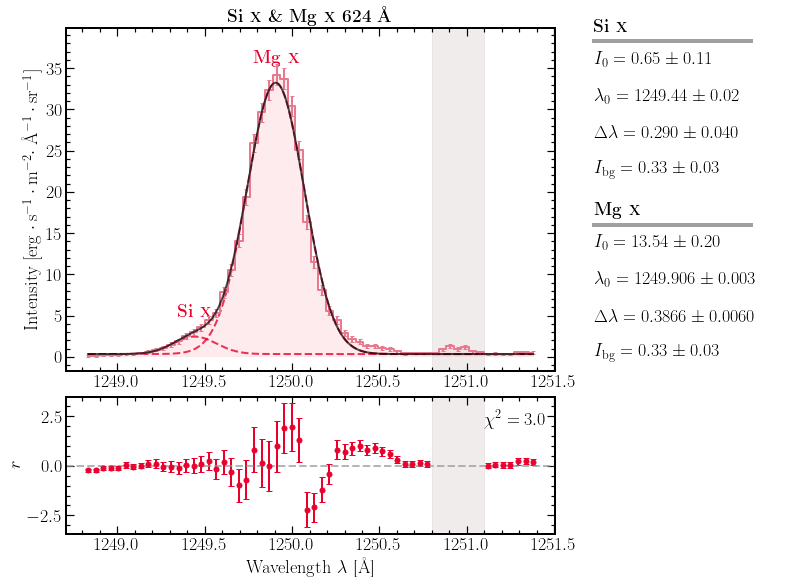

In [117]:
SiX_MgX_624_slice = (915,975)
wvl_SiX_MgX_624 = wvl_607[SiX_MgX_624_slice[0]:SiX_MgX_624_slice[1]]
radiometry_SiX_MgX_624 = radiometry(1,wvl_SiX_MgX_624/2.,2,np.ones_like(wvl_SiX_MgX_624),bare=True,kbr=False,photons=False,watts=True,det_a=False,
                                det_b=True,joint=False,separate=True)*1.e3
int_SiX_MgX_624 = np.average(sumer_607_window[-30:,SiX_MgX_624_slice[0]:SiX_MgX_624_slice[1]],axis=0)*radiometry_SiX_MgX_624
err_SiX_MgX_624 = np.sqrt(np.sum(300*sumer_607_window[-30:,SiX_MgX_624_slice[0]:SiX_MgX_624_slice[1]],
                        axis=0))/30/300*radiometry_SiX_MgX_624

SiX_MgX_624_fit_model = SpectrumFitSingle(data=int_SiX_MgX_624,wvl=wvl_SiX_MgX_624,err=err_SiX_MgX_624,
                                      same_width=False,line_number=2,line_wvl_init=[1249.5,1249.9],
                                      int_max_init=[5,35],fwhm_init=[0.2,0.2],mask=[[1250.8,1251.1]])
#SiX_MgX_624_fit_model.plot(plot_fit=False,plot_params=False)
SiX_MgX_624_fit_model.run_lse()
# SiX_MgX_624_fit_model.run_HahnMC(n_chain=10000)
SiX_MgX_624_fit_model.plot(plot_title=r"\textbf{Si \textsc{x} \& Mg \textsc{x} 624 \mbox{\AA}}",
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                                 line_caption = [r"\textbf{Si \textsc{x}}",r"\textbf{Mg \textsc{x}}"],
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot m^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,SiX_MgX_624_fit_model.line_wvl_fit/2.,2,SiX_MgX_624_fit_model.fwhm_fit*1000./2.,DET_B=True))

FWHM after removing instrumental broadening:  [204.13 137.68 301.52]


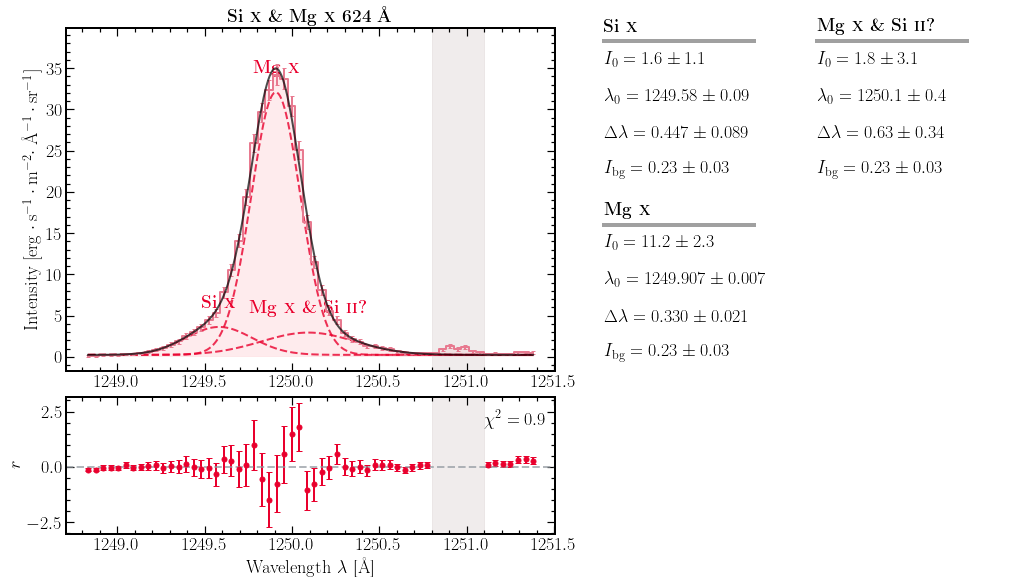

In [118]:
SiX_MgX_624_fit_model = SpectrumFitSingle(data=int_SiX_MgX_624,wvl=wvl_SiX_MgX_624,err=err_SiX_MgX_624,
                                      same_width=False,line_number=3,line_wvl_init=[1249.5,1249.9,1249.9],
                                      int_max_init=[5,35,4],fwhm_init=[0.2,0.2,0.4],mask=[[1250.8,1251.1]])
#SiX_MgX_624_fit_model.plot(plot_fit=False,plot_params=False)
SiX_MgX_624_fit_model.run_lse()
# SiX_MgX_624_fit_model.run_HahnMC(n_chain=10000)
SiX_MgX_624_fit_model.plot(plot_title=r"\textbf{Si \textsc{x} \& Mg \textsc{x} 624 \mbox{\AA}}",
                                 xlabel=r"Wavelength $\lambda$ [\mbox{\AA}]",
                                 line_caption = [r"\textbf{Si \textsc{x}}",r"\textbf{Mg \textsc{x}}",
                                 r"\textbf{Mg \textsc{x} \& Si \textsc{ii}?}"],
                               ylabel=r"Intensity $\mathrm{[erg\cdot s^{-1}\cdot m^{-2}\cdot}$ \mbox{\AA}$\mathrm{^{-1}\cdot sr^{-1}]}$",
                              color_style="Red")
print("FWHM after removing instrumental broadening: ",
con_width_funct_4(1,SiX_MgX_624_fit_model.line_wvl_fit/2.,2,SiX_MgX_624_fit_model.fwhm_fit*1000./2.,DET_B=True))

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:202: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


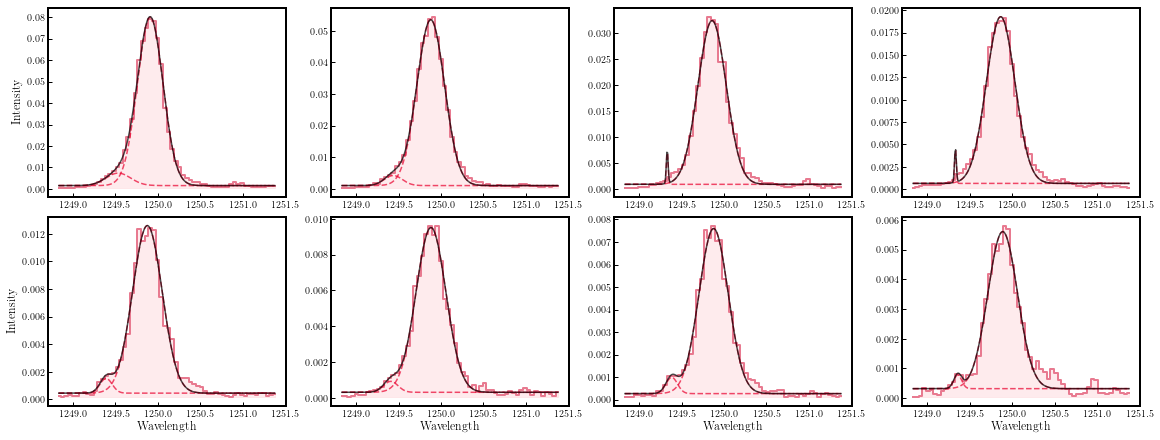

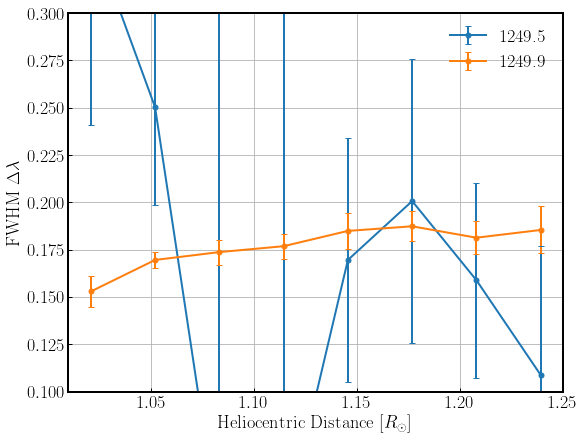

In [119]:
int_SiX_MgX_624_row = np.flip(np.average(sumer_607_window[-240:,SiX_MgX_624_slice[0]:SiX_MgX_624_slice[1]].reshape(-1,30,SiX_MgX_624_slice[1]-SiX_MgX_624_slice[0]),axis=1),axis=0)

SiX_MgX_624_fit_row_model = SpectrumFitRow(data=int_SiX_MgX_624_row,wvl=wvl_SiX_MgX_624,err=None,
                                      same_width=False,line_number=2,line_wvl_init=[1249.5,1249.9],
                                      int_max_init=[0.01,0.06],fwhm_init=[0.2,0.2])
SiX_MgX_624_fit_row_model.run_lse()
SiX_MgX_624_fit_row_model.plot_fit()
SiX_MgX_624_fit_row_model.fwhm_fit[:,1] = con_width_funct_4(1,SiX_MgX_624_fit_row_model.line_wvl_fit[:,1]/2.,2, SiX_MgX_624_fit_row_model.fwhm_fit[:,1]*1000./2.,DET_B=True)/1000
ax = SiX_MgX_624_fit_row_model.plot_variation(xdata=np.average(sumer_ycoord[:240].reshape(-1,30),axis=1)/960,
                                            xlabel=r"Heliocentric Distance $\left[R_\odot \right]$",
                                            ylim=(0.1,0.3))
ax.grid("on")